# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de Gran canaria

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'gray'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_GranCanaria = datos[datos['isla'] == 'GRAN CANARIA']
datos_GranCanaria = datos_GranCanaria.set_index('fecha')

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']      # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                              # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']  # Atributos para el análisis de todas las variables


objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a agrupar 
isla = 'Gran Canaria'     # Isla a la que se está realziando el estudio
fechas = datos_GranCanaria.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:
datos_GranCanaria_uni = datos_GranCanaria[objetivo]
datos_GranCanaria_uni_arr = np.array(datos_GranCanaria_uni).reshape(-1, 1)

datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']]
datos_GranCanaria_mult_atm = datos_GranCanaria[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_GranCanaria_mult_total = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_uni_scaled = scaler.fit_transform(datos_GranCanaria_uni_arr)

In [7]:
n_train = len(datos_GranCanaria_uni_scaled) - dias_prediccion


train = datos_GranCanaria_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_uni_scaled[n_train - dias_prediccion:len(datos_GranCanaria_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0536 - val_loss: 0.0621
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0485 - val_loss: 0.0603
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0528 - val_loss: 0.0522
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0381 - val_loss: 0.0378
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274 - val_loss: 0.0304
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0263 - val_loss: 0.0325
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0229 - val_loss: 0.0276
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0294
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203 - val_loss: 0.0280
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 - val_loss: 0.0263
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - val_loss: 0.0316
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 - val_loss: 0.024

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 563.376
2022-03-20: número de casos reales 461, número de casos predichos 573.1856
2022-03-21: número de casos reales 948, número de casos predichos 588.51764
2022-03-22: número de casos reales 966, número de casos predichos 616.92773
2022-03-23: número de casos reales 948, número de casos predichos 691.43414
2022-03-24: número de casos reales 790, número de casos predichos 768.47424
2022-03-25: número de casos reales 741, número de casos predichos 806.9881
2022-03-26: número de casos reales 428, número de casos predichos 844.5458
2022-03-27: número de casos reales 368, número de casos predichos 875.7593
2022-03-28: número de casos reales 528, número de casos predichos 882.274


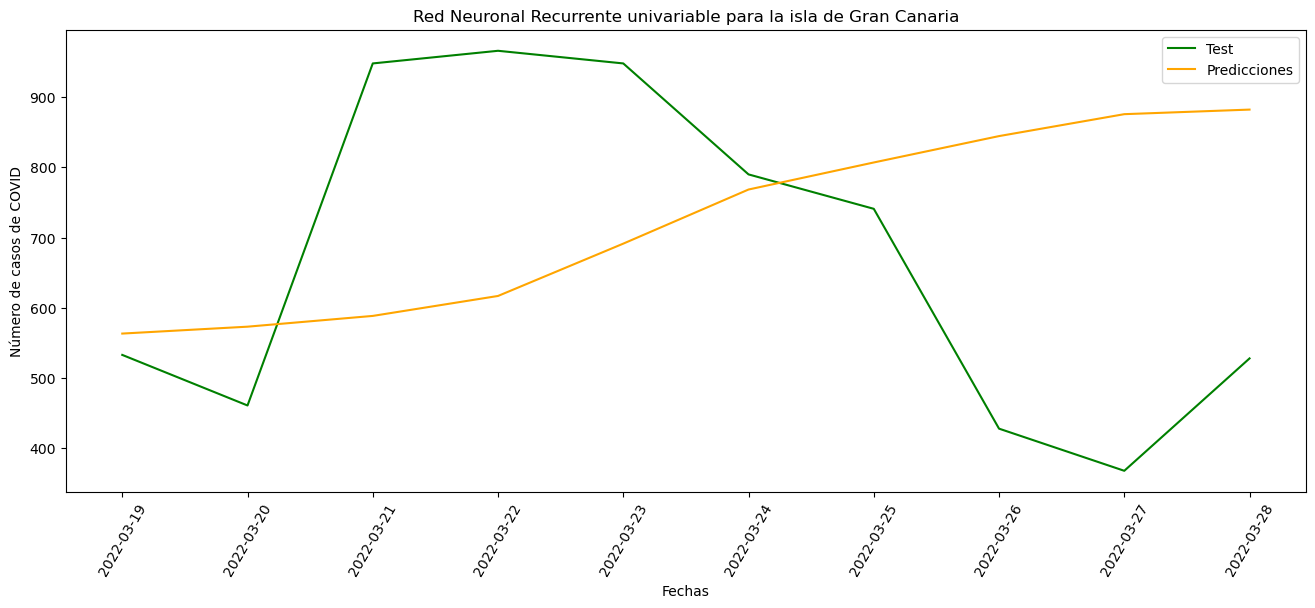

In [12]:
isla = 'Gran Canaria'
fechas = datos_GranCanaria.tail(dias_prediccion).index
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

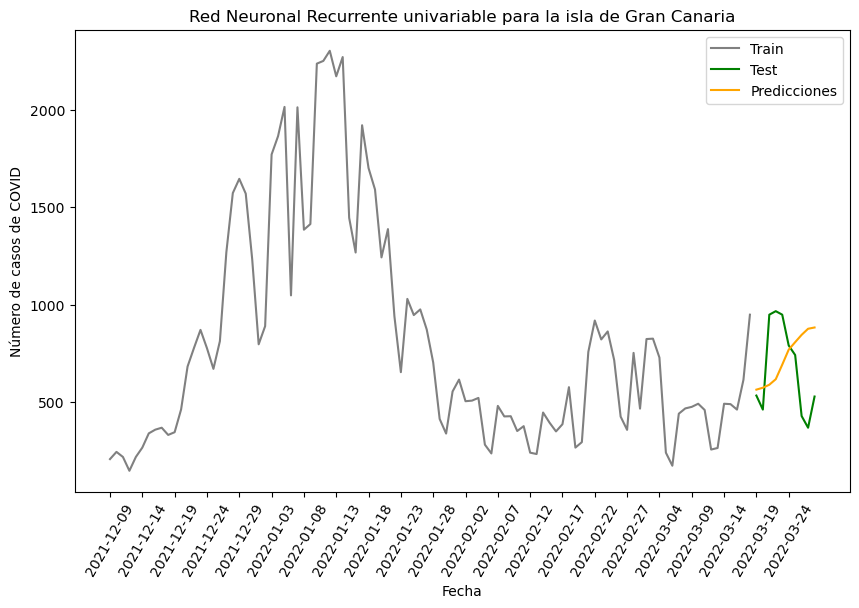

In [13]:
datos_train = datos_GranCanaria_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 89207.10764787979
Error absoluto medio (MAE) del modelo: 247.37749633789062
Raíz del error cuadrático medio (RMSE) del modelo: 298.6755893069934


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled = scaler.fit_transform(datos_GranCanaria_mult_covid)

In [16]:
# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_covid[objetivo]).reshape(-1, 1))

In [17]:
n_train = len(datos_GranCanaria_mult_covid_scaled) - dias_prediccion


train = datos_GranCanaria_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_covid_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_covid_scaled), :]

In [18]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [19]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0505 - val_loss: 0.0570
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0374 - val_loss: 0.0551
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0265 - val_loss: 0.0494
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250 - val_loss: 0.0507
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0248 - val_loss: 0.0411
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0217 - val_loss: 0.0769
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0231 - val_loss: 0.0379
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0209 - val_loss: 0.0766
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - val_loss: 0.0374
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - val_loss: 0.0389
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0438
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - val_loss: 0.0300

In [20]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


In [21]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 313.00336
2022-03-20: número de casos reales 461, número de casos predichos 323.2746
2022-03-21: número de casos reales 948, número de casos predichos 336.16302
2022-03-22: número de casos reales 966, número de casos predichos 359.63065
2022-03-23: número de casos reales 948, número de casos predichos 405.50726
2022-03-24: número de casos reales 790, número de casos predichos 449.3573
2022-03-25: número de casos reales 741, número de casos predichos 469.50177
2022-03-26: número de casos reales 428, número de casos predichos 487.76984
2022-03-27: número de casos reales 368, número de casos predichos 514.1971
2022-03-28: número de casos reales 528, número de casos predichos 526.35284


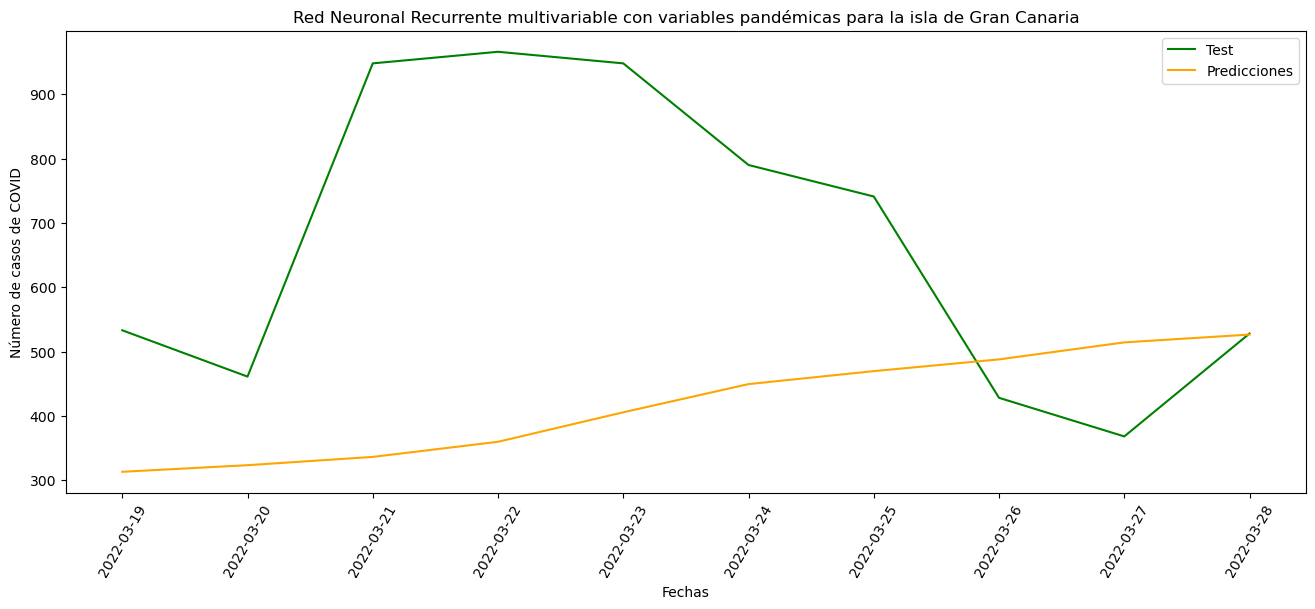

In [22]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

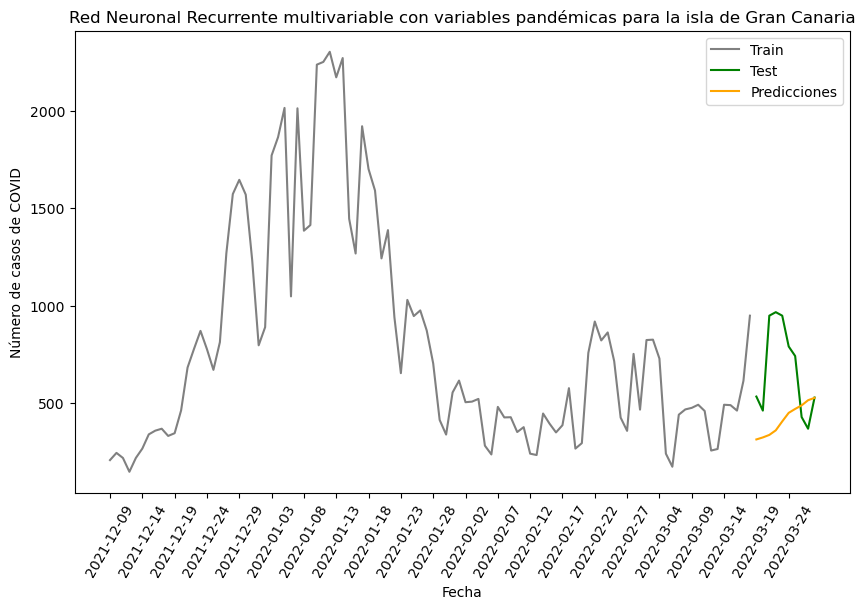

In [23]:
datos_train = datos_GranCanaria_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [24]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 131839.09283967028
Error absoluto medio (MAE) del modelo: 293.81761169433594
Raíz del error cuadrático medio (RMSE) del modelo: 363.09653377534505


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled = scaler.fit_transform(datos_GranCanaria_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_atm[objetivo]).reshape(-1, 1))

In [26]:
n_train = len(datos_GranCanaria_mult_atm_scaled) - dias_prediccion


train = datos_GranCanaria_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_atm_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_atm_scaled), :]

In [27]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [28]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0520 - val_loss: 0.0579
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0433 - val_loss: 0.0532
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0363 - val_loss: 0.0343
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0287 - val_loss: 0.0331
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0231 - val_loss: 0.0312
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234 - val_loss: 0.0368
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - val_loss: 0.0244
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - val_loss: 0.0259
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0229 - val_loss: 0.0258
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - val_loss: 0.0240
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - val_loss: 0.0241
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - val_loss: 0.0224

In [29]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


In [30]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 551.92816
2022-03-20: número de casos reales 461, número de casos predichos 554.8176
2022-03-21: número de casos reales 948, número de casos predichos 563.164
2022-03-22: número de casos reales 966, número de casos predichos 589.7016
2022-03-23: número de casos reales 948, número de casos predichos 652.4884
2022-03-24: número de casos reales 790, número de casos predichos 715.3378
2022-03-25: número de casos reales 741, número de casos predichos 777.6311
2022-03-26: número de casos reales 428, número de casos predichos 834.1641
2022-03-27: número de casos reales 368, número de casos predichos 866.56244
2022-03-28: número de casos reales 528, número de casos predichos 862.64923


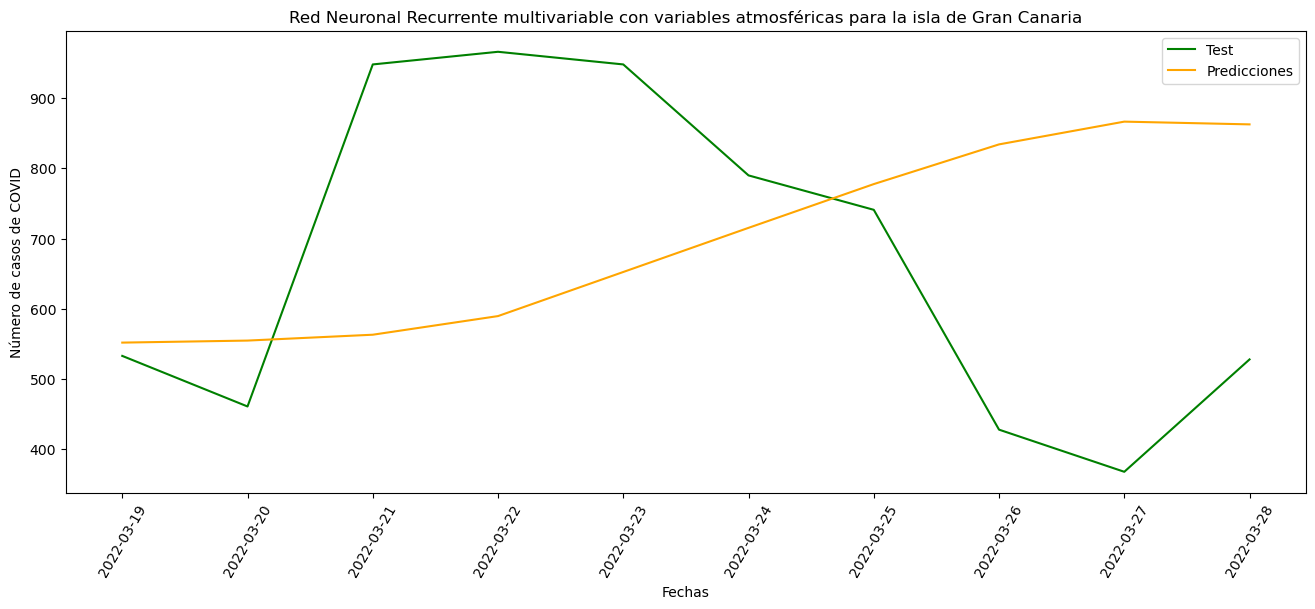

In [31]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

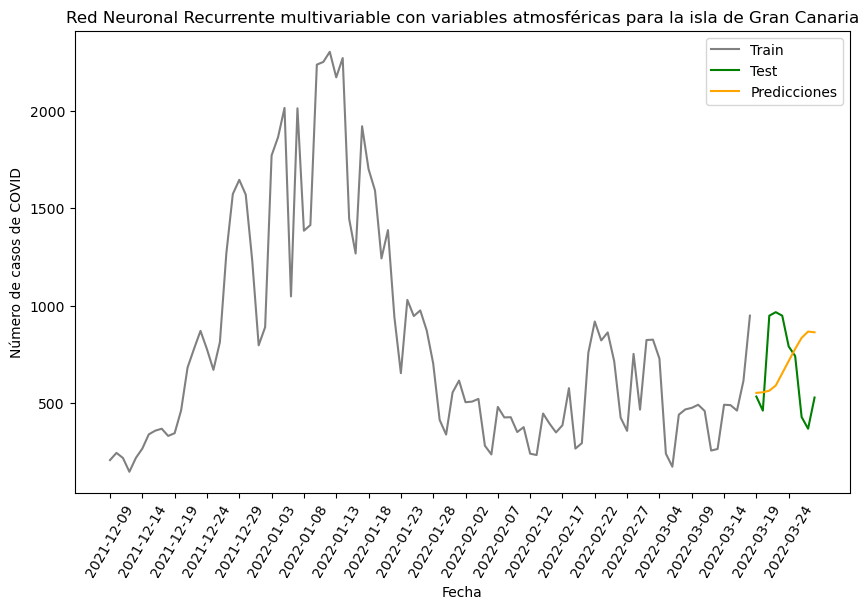

In [32]:
datos_train = datos_GranCanaria_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [33]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 91862.65444831364
Error absoluto medio (MAE) del modelo: 252.00608520507814
Raíz del error cuadrático medio (RMSE) del modelo: 303.0885257615564


# Red Neuronal Recurrente multivariable con todas las variables

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled = scaler.fit_transform(datos_GranCanaria_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_total[objetivo]).reshape(-1, 1))

In [35]:
n_train = len(datos_GranCanaria_mult_total_scaled) - dias_prediccion


train = datos_GranCanaria_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_total_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_total_scaled), :]

In [36]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [37]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0529 - val_loss: 0.0419
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0366 - val_loss: 0.0328
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0271 - val_loss: 0.0296
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225 - val_loss: 0.0241
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - val_loss: 0.0392
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - val_loss: 0.0321
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0185 - val_loss: 0.0260
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190 - val_loss: 0.0323
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - val_loss: 0.0262
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 - val_loss: 0.0348
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - val_loss: 0.0293
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118 - val_loss: 0.031

In [38]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


In [39]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 378.6284
2022-03-20: número de casos reales 461, número de casos predichos 399.7674
2022-03-21: número de casos reales 948, número de casos predichos 405.95798
2022-03-22: número de casos reales 966, número de casos predichos 442.53546
2022-03-23: número de casos reales 948, número de casos predichos 538.3699
2022-03-24: número de casos reales 790, número de casos predichos 622.925
2022-03-25: número de casos reales 741, número de casos predichos 679.711
2022-03-26: número de casos reales 428, número de casos predichos 720.98035
2022-03-27: número de casos reales 368, número de casos predichos 767.6193
2022-03-28: número de casos reales 528, número de casos predichos 777.7529


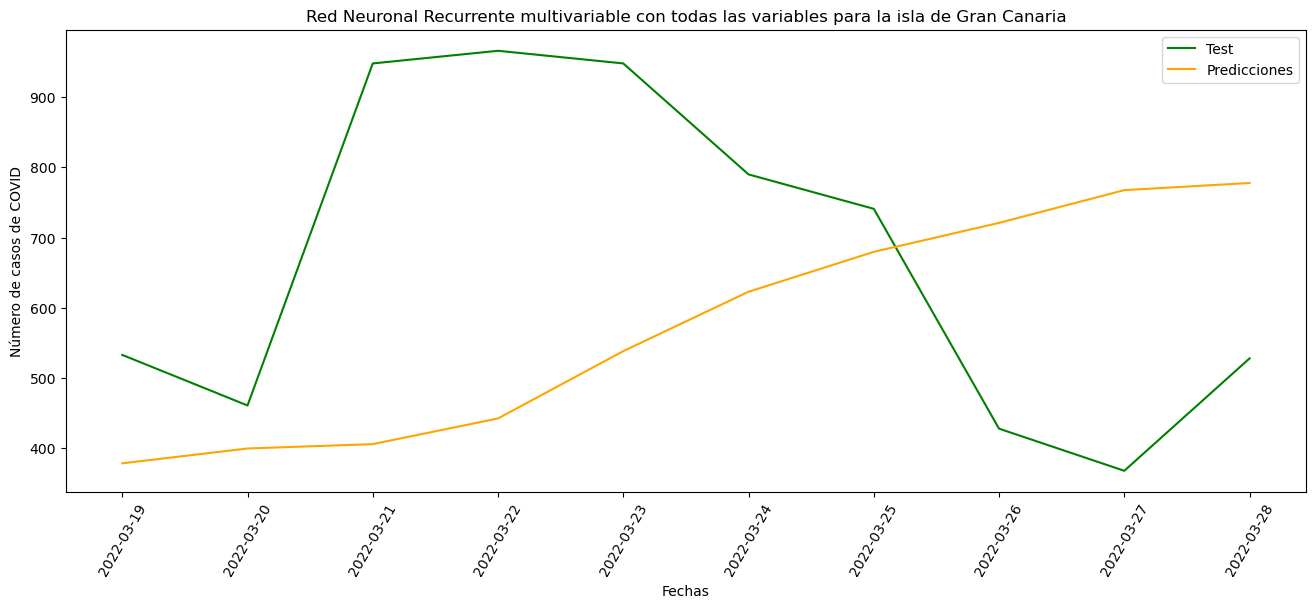

In [40]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

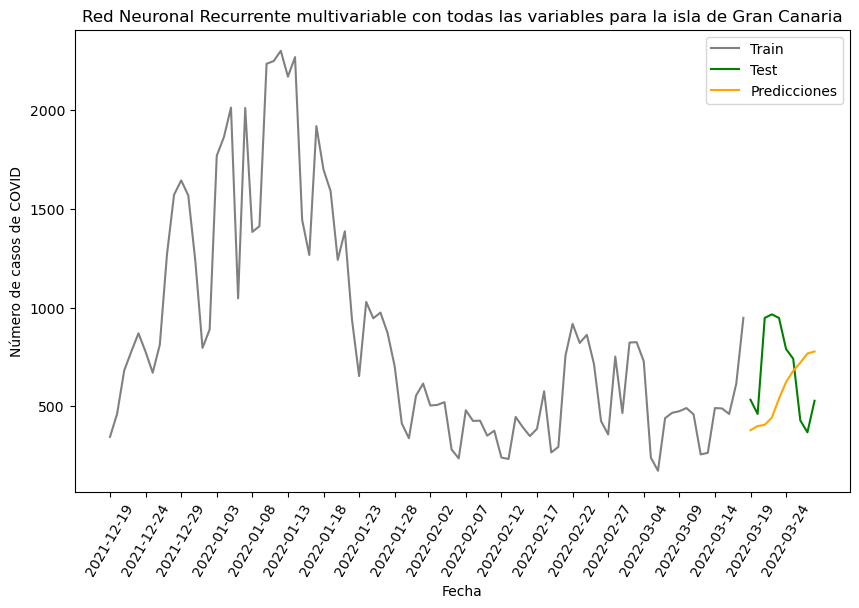

In [41]:
datos_train = datos_GranCanaria_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,90,fechas,tit)

In [42]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 110278.15598355587
Error absoluto medio (MAE) del modelo: 286.145751953125
Raíz del error cuadrático medio (RMSE) del modelo: 332.0815502004829
